In [1]:
import pandas as pd
from plotnine import *
import re

import sys
sys.path.insert(0, '../CODE/')
from visualization_utils import COLORS

Matplotlib is building the font cache; this may take a moment.


# Hyperparameter tuning:
- Randomly chose 10% of the TFs for tuning and 90% for downstream cross validation
- The parameters being tuned:
   1. Learning rate
   2. Leaf paritioning regularizer
   3. Subsampling rate
- The max number of tuning iteration is set to 100
- The following results show the cross-TF validaiton on the 90% holdout TFs

# Yeast calling cards

In [2]:
tun_df = pd.read_csv('../OUTPUT/yeast_14tfs_cc_hp_tun_500trees/stats.csv.gz')
tun_df['tuning'] = 'True'

base_df = pd.read_csv('../OUTPUT/yeast_14tfs_cc_hp_base_500trees/stats.csv.gz')
base_df['tuning'] = 'False'

df = pd.concat([tun_df, base_df])

df2 = tun_df.merge(base_df, on=['cv', 'tf'])
df2['improv_frac'] = (df2['auprc_x'] - df2['auprc_y']) / df2['auprc_y']

# Sort TFs by baseline AUPRC
df['tf'] = pd.Categorical(
    df['tf'], ordered=True,
    categories=base_df.sort_values('auprc')['tf'].values
)

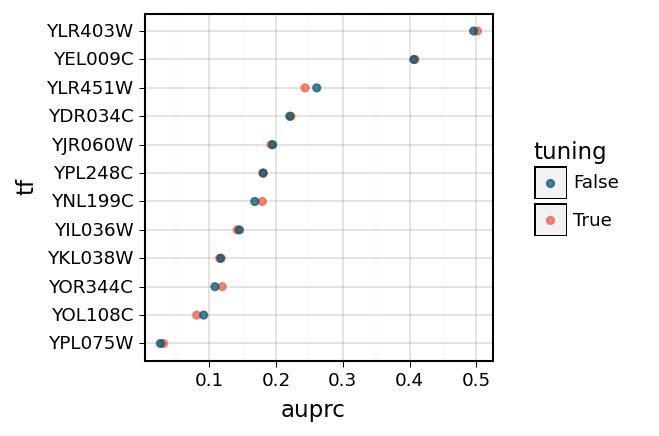

<ggplot: (-9223369042571718396)>

In [3]:
(
    ggplot(df, aes(x='auprc', y='tf', color='tuning'))
    + geom_point(alpha=.7)
    + scale_color_manual([COLORS['dark_blue'], COLORS['orange']])
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

Comparing the cross-TF valdiaiton with the tuned parameters vs the same TFs without (baseline), 2-3 TFs are improved and 2-3 are penalized.

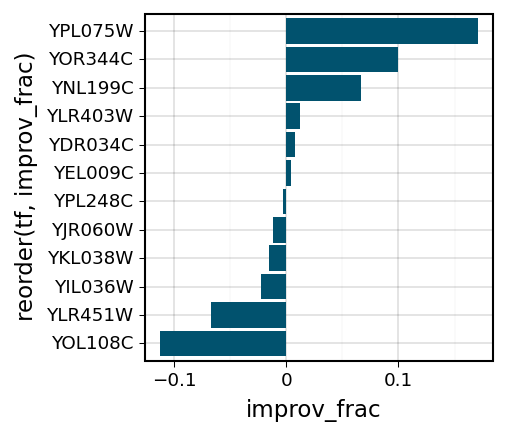

<ggplot: (2994283057416)>

In [4]:
(
    ggplot(df2, aes(x='reorder(tf, improv_frac)', y='improv_frac'))
    + geom_bar(stat='identity', fill=COLORS['dark_blue'])
    + coord_flip()
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

It is confirmed by looking at the fraction of improvement over the baseline AUPRC. The gain and lose are even.

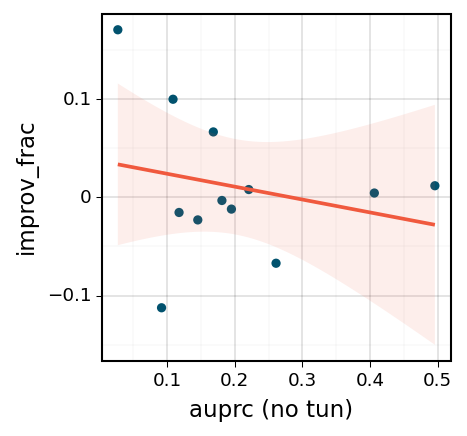

<ggplot: (2994283092765)>

In [5]:
(
    ggplot(df2, aes(x='auprc_y', y='improv_frac'))
    + geom_point(color=COLORS['dark_blue'])
    + geom_smooth(method='lm', color=COLORS['orange'], fill=COLORS['orange'], alpha=.1)
    + labs(x='auprc (no tun)')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

The result of tuning does not strongly favor TFs with higher or lower baseline AUPRC.

# Yeast ChIP-exo

In [6]:
tun_df = pd.read_csv('../OUTPUT/yeast_19tfs_chipexo_hp_tun_500trees/stats.csv.gz')
tun_df['tuning'] = True

base_df = pd.read_csv('../OUTPUT/yeast_19tfs_chipexo_hp_base_500trees/stats.csv.gz')
base_df['tuning'] = False

df = pd.concat([tun_df, base_df])

df2 = tun_df.merge(base_df, on=['cv', 'tf'])
df2['improv_frac'] = (df2['auprc_x'] - df2['auprc_y']) / df2['auprc_y']

# Sort TFs by baseline AUPRC
df['tf'] = pd.Categorical(
    df['tf'], ordered=True,
    categories=base_df.sort_values('auprc')['tf'].values
)

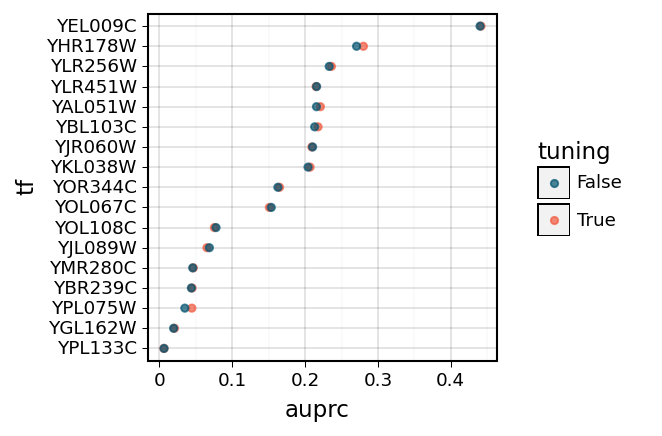

<ggplot: (-9223369042571099704)>

In [7]:
(
    ggplot(df, aes(x='auprc', y='tf', color='tuning'))
    + geom_point(alpha=.7)
    + scale_color_manual([COLORS['dark_blue'], COLORS['orange']])
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

Comparing the tuned vs baseline, a number of TFs are improved and by a reasonable margin. And no TFs are penalized signficantly.

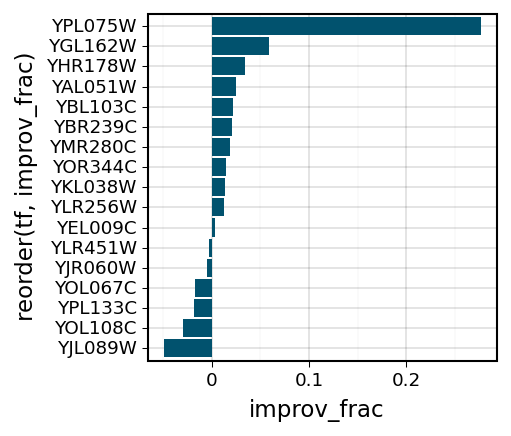

<ggplot: (2994241240426)>

In [8]:
df2 = df2.sort_values('improv_frac')

(
    ggplot(df2, aes(x='reorder(tf, improv_frac)', y='improv_frac'))
    + geom_bar(stat='identity', fill=COLORS['dark_blue'])
    + coord_flip()
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

Fraction of improvement confirms it.

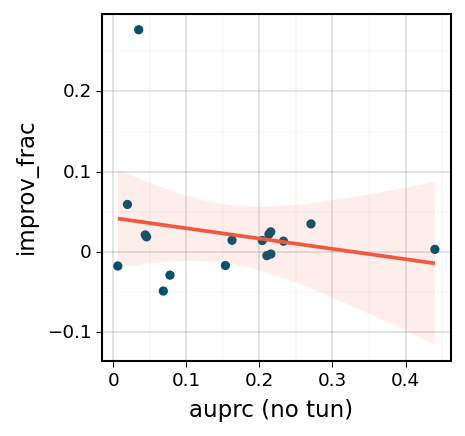

<ggplot: (-9223369042571102590)>

In [9]:
(
    ggplot(df2, aes(x='auprc_y', y='improv_frac'))
    + geom_point(color=COLORS['dark_blue'])
    + geom_smooth(method='lm', color=COLORS['orange'], fill=COLORS['orange'], alpha=.1)
    + labs(x='auprc (no tun)')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

No AUPRC bias observed.

# Human K562

In [7]:
tun_df = pd.DataFrame()

with open('../LOG/human_k562_hp_tun_32450285.out', 'r') as f:
    lines = f.readlines()
    
    for line in lines:
        if 'CV performance' in line:
            found = re.findall(r'TF (.+?) in (.+?) AUPRC=(.+?)\n', line)
            
            if len(found) > 0:
                tf, _, auc = found[0]
                tun_df = tun_df.append(pd.Series({
                    'tf': tf,
                    'auprc': float(auc)
                }), ignore_index=True)

tun_df['tuning'] = 'True'

In [15]:
base_df = pd.read_csv('../OUTPUT/human_42tfs_k562_hp_base/stats.csv.gz')
base_df['tuning'] = 'False'

orig_df = pd.read_csv('../OUTPUT/human_42tfs_k562/stats.csv.gz')
orig_df['tuning'] = 'Original'

tf_list = set(tun_df.loc[~tun_df['auprc'].isnull(), 'tf'].tolist()) & set(base_df.loc[~base_df['auprc'].isnull(), 'tf'].tolist())

In [39]:
df = pd.concat([
    tun_df[tun_df['tf'].isin(tf_list)], 
    base_df[base_df['tf'].isin(tf_list)], 
    orig_df[orig_df['tf'].isin(tf_list)]
])

df2 = tun_df.merge(base_df, on=['tf'])
df2['improv_frac'] = (df2['auprc_x'] - df2['auprc_y']) / df2['auprc_y']
df2 = df2[df2['tf'].isin(tf_list)]

# Sort TFs by baseline AUPRC
df['tf'] = pd.Categorical(
    df['tf'], ordered=True,
    categories=base_df[base_df['tf'].isin(tf_list)].sort_values('auprc')['tf'].values
)

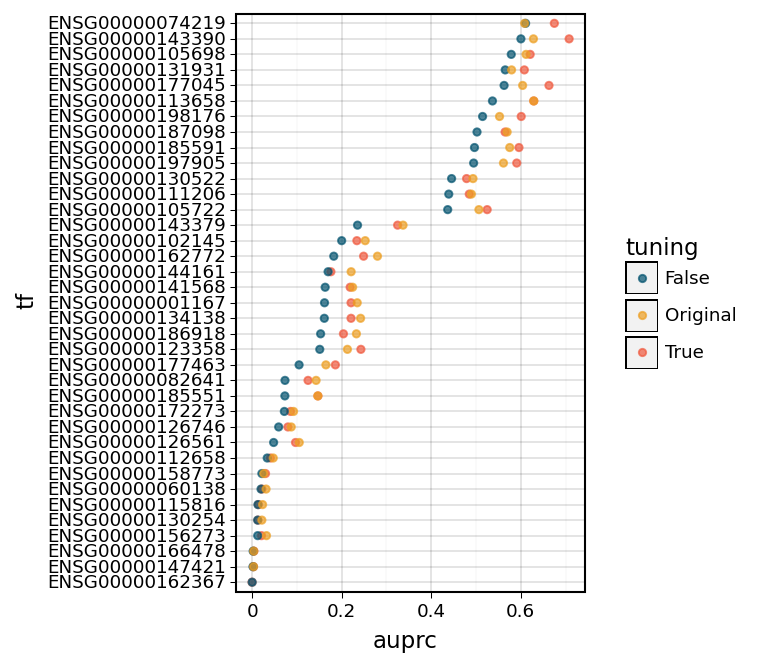

<ggplot: (3000132701732)>

In [35]:
(
    ggplot(df, aes(x='auprc', y='tf', color='tuning'))
    + geom_point(alpha=.7)
    + scale_color_manual([COLORS['dark_blue'], COLORS['yellow'], COLORS['orange']])
    + theme_linedraw()
    + theme(figure_size=(3, 5), dpi=150)
)

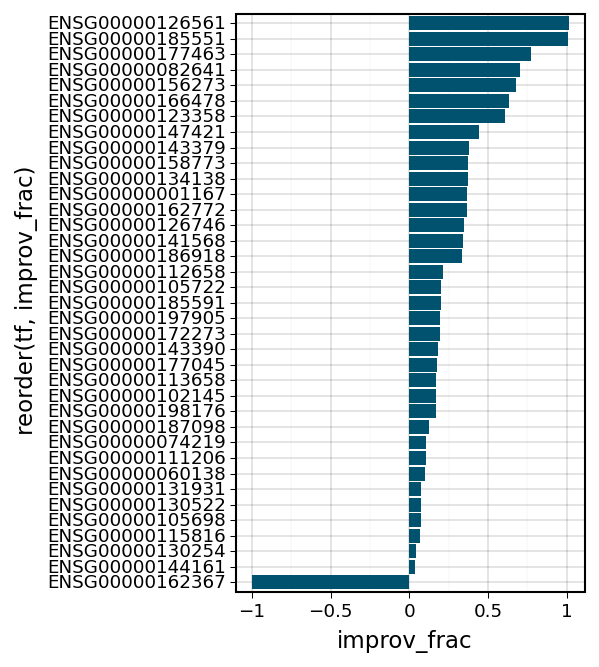

<ggplot: (-9223369036723152815)>

In [40]:
df2 = df2.sort_values('improv_frac')

(
    ggplot(df2, aes(x='reorder(tf, improv_frac)', y='improv_frac'))
    + geom_bar(stat='identity', fill=COLORS['dark_blue'])
    + coord_flip()
    + theme_linedraw()
    + theme(figure_size=(3, 5), dpi=150)
)

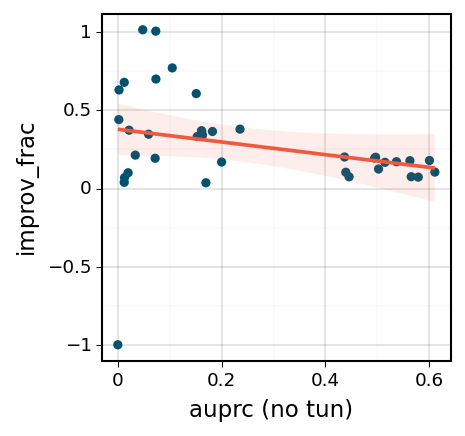

<ggplot: (-9223369036724246805)>

In [41]:
(
    ggplot(df2, aes(x='auprc_y', y='improv_frac'))
    + geom_point(color=COLORS['dark_blue'])
    + geom_smooth(method='lm', color=COLORS['orange'], fill=COLORS['orange'], alpha=.1)
    + labs(x='auprc (no tun)')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

# Human - HEK293

In [2]:
tun_df = pd.read_csv('../OUTPUT/human_80tfs_hek293_hp_tun/stats.csv.gz')
tun_df['tuning'] = 'True'

base_df = pd.read_csv('../OUTPUT/human_80tfs_hek293_hp_base/stats.csv.gz')
base_df['tuning'] = 'False'

orig_df = pd.read_csv('../OUTPUT/human_80tfs_hek293/stats.csv.gz')
orig_df['tuning'] = 'Orig'
orig_df = orig_df[orig_df['tf'].isin(base_df['tf'])]

In [3]:
df = pd.concat([tun_df, base_df, orig_df])

df2 = tun_df.merge(base_df, on=['tf'])
df2['improv_frac'] = (df2['auprc_x'] - df2['auprc_y']) / df2['auprc_y']

# Sort TFs by baseline AUPRC
df['tf'] = pd.Categorical(
    df['tf'], ordered=True,
    categories=base_df.sort_values('auprc')['tf'].values
)

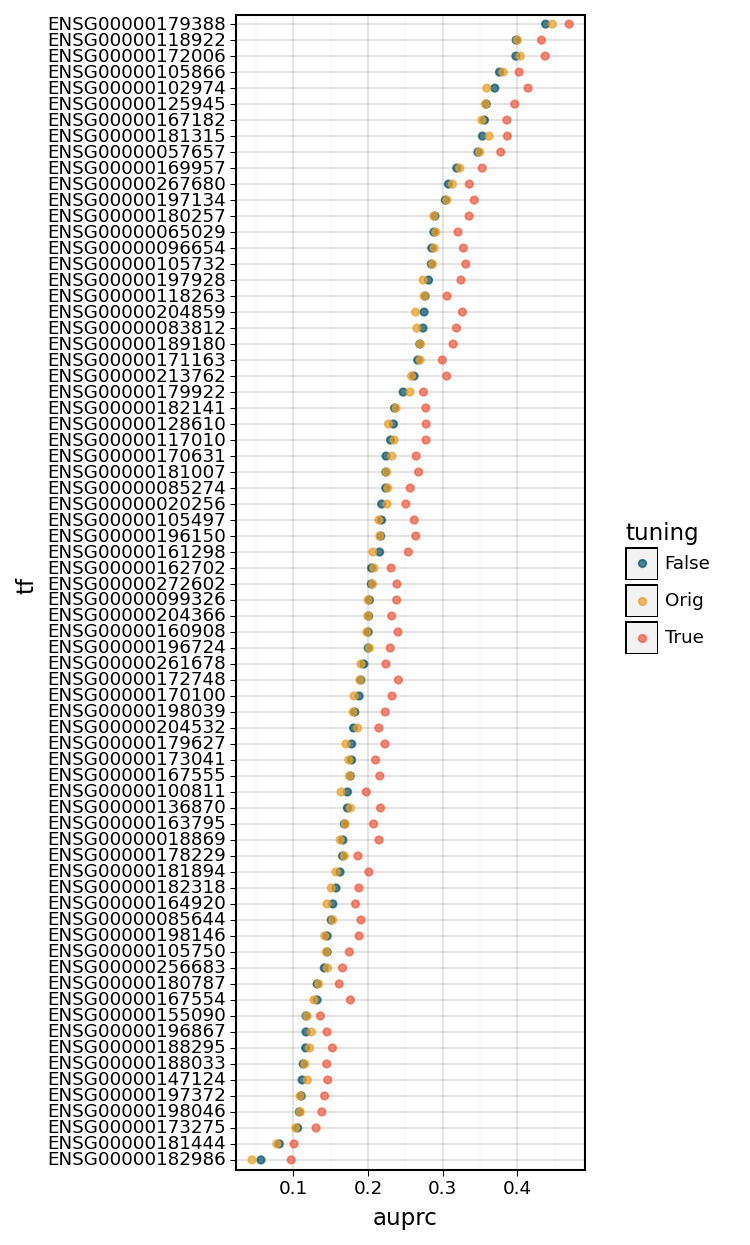

<ggplot: (3000129500964)>

In [4]:
(
    ggplot(df, aes(x='auprc', y='tf', color='tuning'))
    + geom_point(alpha=.7)
    + scale_color_manual([COLORS['dark_blue'], COLORS['yellow'], COLORS['orange']])
    + theme_linedraw()
    + theme(figure_size=(3, 10), dpi=150)
)

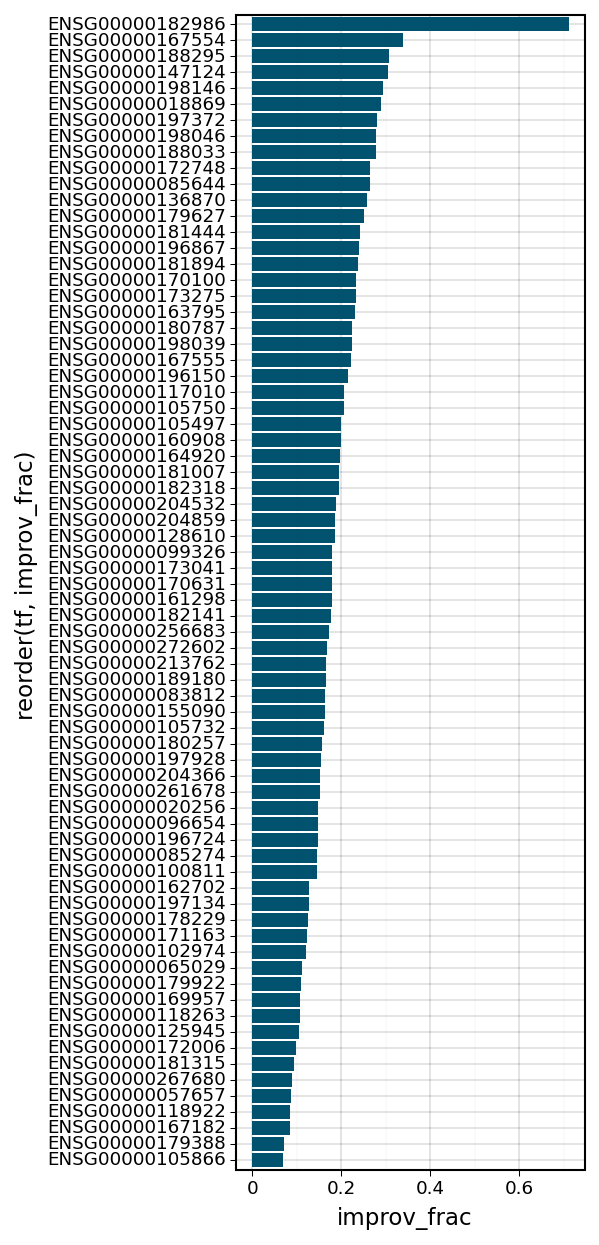

<ggplot: (-9223369036725289931)>

In [5]:
df2 = df2.sort_values('improv_frac')

(
    ggplot(df2, aes(x='reorder(tf, improv_frac)', y='improv_frac'))
    + geom_bar(stat='identity', fill=COLORS['dark_blue'])
    + coord_flip()
    + theme_linedraw()
    + theme(figure_size=(3, 10), dpi=150)
)

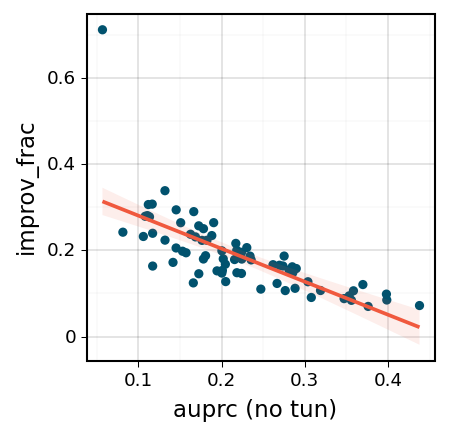

<ggplot: (3000130744689)>

In [6]:
(
    ggplot(df2, aes(x='auprc_y', y='improv_frac'))
    + geom_point(color=COLORS['dark_blue'])
    + geom_smooth(method='lm', color=COLORS['orange'], fill=COLORS['orange'], alpha=.1)
    + labs(x='auprc (no tun)')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)